In [ ]:
import sys
sys.path.insert(0,'python')
from get_modis import *

In [ ]:
fhead = 'data/50SMG20164100'
import glob
import datetime
import calendar
fh = fhead.split('20')[0]
files = glob.glob('%s*B01.jp2'%fh)
dates = []
ds = []
de = []
sys = []
eys = []
for i in files:
    date = datetime.datetime.strptime((i.split('%s'%fh)[1]).split('0B01.jp2')[0], "%Y%m%d")
    dates.append(date)
    doy = date.timetuple().tm_yday
    if doy - 8 <0:
        sys.append(date.year-1)
        days = (datetime.date(date.year,1,1)-datetime.date(date.year-1,1,1)).days
        ds.append(doy-8+days)
    else:
        sys.append(date.year)
        ds.append(doy-8)

    if doy + 8 > 366:
        eys.append(date.year+1)
        days = (datetime.date(date.year+1,1,1)-datetime.date(date.year,1,1)).days
        ds.append(doy+8-days)
    else:
        eys.append(date.year)
        de.append(doy+8)

In [25]:
days = (datetime.date(2016+1,1,1)-datetime.date(2016,1,1)).days

In [ ]:
fhead = 'data/50SMG20164100'
fh = fhead.split('20')[0]
files = glob.glob('%s*B01.jp2'%fh)
dates = []
ds = []
de = []
sys = []
eys = []
for j,i in enumerate(files):
    
    date = datetime.datetime.strptime((i.split('%s'%fh)[1]).split('0B01.jp2')[0], "%Y%m%d")
    if j > 0:
        if (date - dates[-1]).days > 30:
            
            m = ((i.split('%s'%fh)[1]).split('0B01.jp2')[0])[4]
            d = ((i.split('%s'%fh)[1]).split('0B01.jp2')[0])[5:]
            date = datetime.datetime(date.year,int(m),int(d))
            dates.append(date)
        
        elif (date - dates[-1]).days < 0:
            for k in xrange(j):
                m = (files[k].split('%s'%fh)[1]).split('0B01.jp2')[0][4]
                d = (files[k].split('%s'%fh)[1]).split('0B01.jp2')[0][5:]
                dates[k] = datetime.datetime(date.year,int(m),int(d))
           
            
        else:
            dates.append(date)
    else:
        dates.append(date)
    doy = date.timetuple().tm_yday
    if doy - 8 <= 0:
        
        sys.append(date.year-1)
        days = (datetime.date(date.year,1,1)-datetime.date(date.year-1,1,1)).days
        ds.append(doy-8+days)
        
    else:
        sys.append(date.year)
        ds.append(doy-8)

    if doy + 8 > 366:
        eys.append(date.year+1)
        days = (datetime.date(date.year+1,1,1)-datetime.date(date.year,1,1)).days
        de.append(doy+8-days)
    else:
        eys.append(date.year)
        de.append(doy+8)


for i in range(len(sys)-1):

    if sys[i] == eys[i]:
        get_modisfiles( 'MOTA', 'MCD43A1.005', sys[i], 'h27v05', None, 
                       doy_start=ds[i], doy_end=de[i], out_dir='m_data/' )
        get_modisfiles( 'MOTA', 'MCD43A2.005', sys[i], 'h27v05', None, 
                       doy_start=ds[i], doy_end=de[i], out_dir='m_data/' )
        get_modisfiles( 'MOTA', 'MCD43A3.005', sys[i], 'h27v05', None, 
                       doy_start=ds[i], doy_end=de[i], out_dir='m_data/' )
    else :
        days = (datetime.date(sys[i]+1,1,1)-datetime.date(sys[i],1,1)).days
        
        get_modisfiles( 'MOTA', 'MCD43A1.005',
                       sys[i], 'h27v05', None, doy_start=ds[i],
                       doy_end=days, out_dir='m_data/' )
        get_modisfiles( 'MOTA', 'MCD43A1.005',
                       eys[i], 'h27v05', None, doy_start=1,
                       doy_end=de[i], out_dir='m_data/')
        
        get_modisfiles( 'MOTA', 'MCD43A2.005',
                       sys[i], 'h27v05', None, doy_start=ds[i],
                       doy_end=days, out_dir='m_data/' )
        get_modisfiles( 'MOTA', 'MCD43A2.005',
                       eys[i], 'h27v05', None, doy_start=1,
                       doy_end=de[i], out_dir='m_data/')
        
        get_modisfiles( 'MOTA', 'MCD43A3.005',
                       sys[i], 'h27v05', None, doy_start=ds[i],
                       doy_end=days, out_dir='m_data/' )

        get_modisfiles( 'MOTA', 'MCD43A3.005',
                       eys[i], 'h27v05', None, doy_start=1,
                       doy_end=de[i], out_dir='m_data/')

In [1]:
import numpy as np
from osgeo import ogr
from osgeo import osr
import mgrs
from scipy.interpolate import griddata

wgs84 = osr.SpatialReference( ) # Define a SpatialReference object
wgs84.ImportFromEPSG( 4326 ) # And set it to WGS84 using the EPSG code
modis_sinu = osr.SpatialReference() # define the SpatialReference object
# In this case, we get the projection from a Proj4 string
modis_sinu.ImportFromProj4 ( \
                "+proj=sinu +R=6371007.181 +nadgrids=@null +wktext")
tx = osr.CoordinateTransformation( wgs84, modis_sinu )

modis_x0, modis_y, modis_z = tx.TransformPoint (180, 0)
modis_x1, modis_y, modis_z = tx.TransformPoint (-180, 0)
modis_x, modis_y0, modis_z = tx.TransformPoint (0, 90)
modis_x, modis_y1, modis_z = tx.TransformPoint (0, -90)

#horizontal tilewidth
htw = (modis_x0 - modis_x1)/36.
#cell size
hcs = htw/2400.
# vertical tilewidth
vtw = (modis_y0 - modis_y1)/18.
#vertical cell size 
vcs = vtw/2400.

def m_pc(cd):
    '''
    Single point transformation
    '''
    lat = cd[1]
    lon = cd[0]
    
    m_x, m_y, m_z = tx.TransformPoint (lon, lat)
    h = int((m_x - modis_x1)/htw) # start from 0 so int would be enough
    v = int((modis_y0 - m_y)/vtw) 
    
    
    p_x = np.ceil((m_x - modis_x1)/hcs) - (h)*2400 # start from 0 so h not h-1 
    p_y = np.ceil((modis_y0 - m_y)/vcs) - (v)*2400 # but the pixel start from 1 so use ceil value

    return (h,v,p_x,p_y)

def s_pc(fhead):
    #fhead = 'data/50SMG20164100'
    # generate a list of the forth and fifth letter
    a = map(chr, range(65, 91))
    a.remove('I')
    a.remove('O')
    
    #get the corner coordinates for each tile
    # the mgrs gives the lower left coordinate

    t = fhead.split('201')[0][-5:]
    m1 = t
    m2 = t.replace(t[-1], a[a.index(t[-1])+1])
    m3 = t.replace(t[-2], a[a.index(t[-2])+1])
    m4 = t.replace(t[-2], a[a.index(t[-2])+1]).replace(t[-1], a[a.index(t[-1])+1])
    
    m = mgrs.MGRS()
    b_l = list(m.toLatLon(m1))
    u_l = list(m.toLatLon(m2))
    b_r = list(m.toLatLon(m3))
    u_r = list(m.toLatLon(m4))
    
    '''
    m_bl = m_pc(b_l)
    m_ul = m_pc(u_l)
    m_br = m_pc(b_r)
    m_ur = m_pc(u_r)
    '''
    
    return [u_l, u_r, b_l, b_r]

    '''
    c = s_pc('data/50SMG20164100')

    x = [0, 0, 10980, 10980]
    y = [0,10980, 10980, 0]
    ps = np.array([x,y]).reshape(4,2)
    lats= np.array([lat for lat, lon in c])
    lons = np.array([lon for lat, lon in c])

    grid_x, grid_y = np.mgrid[0:10980, 0:10980]
    p_lat = griddata(ps, lats, (grid_x, grid_y), method='cubic')
    p_lon = griddata(ps, lons, (grid_x, grid_y), method='cubic')
    f_lat = p_lat.ravel()
    f_lon = p_lon.ravel()
    cds = zip(f_lat,f_lon)
    mc = tx.TransformPoints(cds)
    '''


In [15]:
c = np.array(s_pc('data/50SMG20164100'))
c

array([[  37.94208532,  115.86192607],
       [  37.94758957,  117.        ],
       [  37.04089354,  115.87551977],
       [  37.04622248,  117.        ]])

In [17]:
x = [0, 0, 10980, 10980]
y = [0,10980, 0, 10980]
ps = np.array([x,y]).T
ps

array([[    0,     0],
       [    0, 10980],
       [10980,     0],
       [10980, 10980]])

In [19]:
np.mgrid[0:10980, 0:10980].shape

(2, 10980, 10980)

In [ ]:
import multiprocessing
from functools import partial
import numpy as np
c = np.array(s_pc('data/50SMG20164100'))
x = [0, 0, 10980, 10980]
y = [0,10980, 0, 10980]
ps = np.array([x,y]).T

lats = c[:,0]
lons = c[:,1]

def trans(ps, (grid_x, grid_y), coor = None):
    print ps
    coord = coor
    return griddata(ps, coord, (grid_x, grid_y), method='linear')

grid_x, grid_y = np.mgrid[0:10980, 0:10980]

par = partial(trans,ps, (grid_x, grid_y))

pool = multiprocessing.Pool(processes=2)
p_coords = pool.map(par,[c[:,0], c[:,1]],1)
pool.close()
pool.join()


#p_lat = griddata(ps, lats, (grid_x, grid_y), method='cubic')
#p_lon = griddata(ps, lons, (grid_x, grid_y), method='cubic')

f_lat = p_coords[0].ravel()
f_lon = p_coords[1].ravel()
cds = zip(f_lon,f_lat)

mc = tx.TransformPoints(cds)

m_x = np.array([i[0] for i in mc])
m_y = np.array([i[1] for i in mc])

h = ((m_x - modis_x1)/htw).astype(int) 
v = ((modis_y0 - m_y)/vtw).astype(int)

p_x = np.ceil((m_x - modis_x1)/hcs) - (h)*2400 # start from 0 so h not h-1 
p_y = np.ceil((modis_y0 - m_y)/vcs) - (v)*2400


In [15]:
import multiprocessing
from functools import partial
import numpy as np
import numpy as np
from osgeo import ogr
from osgeo import osr
import mgrs
from scipy.interpolate import griddata
import cPickle as pkl

def s_pc(fhead):
    #fhead = 'data/50SMG20164100'
    # generate a list of the forth and fifth letter
    a = map(chr, range(65, 91))
    a.remove('I')
    a.remove('O')
    
    #get the corner coordinates for each tile
    # the mgrs gives the lower left coordinate

    t = fhead.split('201')[0][-5:]
    m1 = t
    m2 = t.replace(t[-1], a[a.index(t[-1])+1])
    m3 = t.replace(t[-2], a[a.index(t[-2])+1])
    m4 = t.replace(t[-2], a[a.index(t[-2])+1]).replace(t[-1], a[a.index(t[-1])+1])
    
    m = mgrs.MGRS()
    
    b_l = list(m.toLatLon(m1))
    u_l = list(m.toLatLon(m2))
    b_r = list(m.toLatLon(m3))
    u_r = list(m.toLatLon(m4))
    
    return [u_l, u_r, b_l, b_r]



def trans(ps, (grid_x, grid_y), coor = None):
    print ps
    coord = coor
    return griddata(ps, coord, (grid_x, grid_y), method='linear')

def coordarray(fhead):
 
    c = np.array(s_pc(fhead))
    x = [0, 0, 10980, 10980]
    y = [0,10980, 0, 10980]
    ps = np.array([x,y]).T

    lats = c[:,0]
    lons = c[:,1]
    grid_x, grid_y = np.mgrid[0:10980, 0:10980]
    
    p_lat = griddata(ps, lats, (grid_x, grid_y), method='linear')
    p_lon = griddata(ps, lons, (grid_x, grid_y), method='linear')
    #par = partial(trans,ps, (grid_x, grid_y))

    #pool = multiprocessing.Pool(processes=2)
    #p_coords = pool.map(par,[c[:,0], c[:,1]],1)
    #pool.close()
    #pool.join()
    
    f_lat = p_lat.ravel()
    f_lon = p_lon.ravel()
    
    cds = zip(f_lon,f_lat)
    mc = tx.TransformPoints(cds)

    m_x = np.array([i[0] for i in mc])
    m_y = np.array([i[1] for i in mc])
    
    return (m_x, m_y, modis_x1, modis_y0)

def cal_coords(fhead):
    
    tx, htw, hcs, vtw, vcs, modis_x1, modis_y0 = geo_transform()
    
    m_x, m_y = coordarray(fhead)
    
    h = ((m_x - modis_x1)/htw).astype(int) 
    v = ((modis_y0 - m_y)/vtw).astype(int)

    p_x = np.ceil((m_x - modis_x1)/hcs) - (h)*2400 # start from 0 so h not h-1 
    p_y = np.ceil((modis_y0 - m_y)/vcs) - (v)*2400
    
    return np.array([p_x, p_y])

def geo_transform():
    # specified for the MODIS and Sentinel 2 geo_transform
    
    wgs84 = osr.SpatialReference( ) # Define a SpatialReference object
    wgs84.ImportFromEPSG( 4326 ) # And set it to WGS84 using the EPSG code
    modis_sinu = osr.SpatialReference() # define the SpatialReference object
    # In this case, we get the projection from a Proj4 string
    modis_sinu.ImportFromProj4 ( \
                "+proj=sinu +R=6371007.181 +nadgrids=@null +wktext")
    tx = osr.CoordinateTransformation( wgs84, modis_sinu )

    modis_x0, modis_y, modis_z = tx.TransformPoint (180, 0)
    modis_x1, modis_y, modis_z = tx.TransformPoint (-180, 0)
    modis_x, modis_y0, modis_z = tx.TransformPoint (0, 90)
    modis_x, modis_y1, modis_z = tx.TransformPoint (0, -90)

    #horizontal tilewidth
    htw = (modis_x0 - modis_x1)/36.
    #cell size
    hcs = htw/2400.
    # vertical tilewidth
    vtw = (modis_y0 - modis_y1)/18.
    #vertical cell size 
    vcs = vtw/2400.
    
    return (tx, htw, hcs, vtw, vcs, modis_x1, modis_y0)

coords = cal_coords('50SMG20164100')
pkl.dump(coords, open('pkls/50SMGcoords.pkl', 'wb'))

In [89]:
x = [0, 0, 10980, 10980]
y = [0,10980, 0, 10980]
ps = np.array([x,y]).T
ps

array([[    0,     0],
       [    0, 10980],
       [10980,     0],
       [10980, 10980]])

In [83]:
c = s_pc('data/50SMG20164100')

In [80]:
c = [i[::-1] for i in c]

In [81]:
c

[(115.86192606806833, 37.942085319765845),
 (117.0, 37.94758957178304),
 (115.87551977006001, 37.040893542510126),
 (117.0, 37.04622247590853)]

In [82]:
for i in c:
    print m_pc(i)

(27, 5, 330.0, 494.0)
(27, 5, 544.0, 493.0)
(27, 5, 599.0, 711.0)
(27, 5, 813.0, 709.0)


In [2]:
import numpy as np
x = [0, 0, 10980, 10980]
y = [0,10980, 10980, 0]
ps = np.array([x,y]).reshape(4,2)

In [3]:
ps

array([[    0,     0],
       [10980, 10980],
       [    0, 10980],
       [10980,     0]])

In [ ]:
x = [0, 0, 10980, 10980]
y = [0,10980, 10980, 0]
ps = np.array([x,y]).reshape(4,2)
lats= np.array([lat for lat, lon in c])
lons = np.array([lon for lat, lon in c])

grid_x, grid_y = np.mgrid[0:10980, 0:10980]
p_lat = griddata(ps, lats, (grid_x, grid_y), method='cubic')
p_lon = griddata(ps, lons, (grid_x, grid_y), method='cubic')
f_lat = p_lat.ravel()
f_lon = p_lon.ravel()
cds = zip(f_lon,f_lat)
mc = tx.TransformPoints(cds)

del cds

'''
m_x = np.array([i[0] for i in mc])
m_y = np.array([i[1] for i in mc])
'''

h = ((m_x - modis_x1)/htw).astype(int) 
v = ((modis_y0 - m_y)/vtw).astype(int)

p_x = np.ceil((m_x - modis_x1)/hcs) - (h)*2400 # start from 0 so h not h-1 
p_y = np.ceil((modis_y0 - m_y)/vcs) - (v)*2400 # but the pixel start from 1 so use ceil value

In [53]:
tx.TransformPoints(((115.11111111,6.1111111),(34.111111111,115.11111111),(115.111111111111111,35.11111111111111)))

[(12727048.871434653, 679525.3163995972, 0.0),
 (inf, inf, 0.0),
 (10470713.807612179, 3904181.8249580157, 0.0)]

In [13]:
mb="""459–479
545–565
620–670
841–876
1230–1250
1628–1652
2105–2155"""
mb = [i.split('\xe2\x80\x93') for i in mb.split('\n')]

In [14]:
mb = [(float(i),float(j)) for i,j in mb]
mb = [(i,j-i) for i,j in mb]

In [26]:
sb = """443	20
490	65
560	35
665	30
705	15
740	15
783	20
842	115
865	20
945	20
1380	30
1610	90
2190	180"""
sb= [i.split('\t') for i in sb.split('\n')]

In [23]:
sb = [(float(i)-float(j)/2,float(j)) for i,j in sb]

In [27]:
sb = [[float(i)-float(j)/2,float(i)+float(j)/2] for i,j in sb]
import numpy as np
sb = np.array(sb).T
sb[0][np.array([1,2,3,7,8,11,12])], sb[1][np.array([1,2,3,7,8,11,12])]

(array([  457.5,   542.5,   650. ,   784.5,   855. ,  1565. ,  2100. ]),
 array([  522.5,   577.5,   680. ,   899.5,   875. ,  1655. ,  2280. ]))

In [28]:
sb

array([[  433. ,   457.5,   542.5,   650. ,   697.5,   732.5,   773. ,
          784.5,   855. ,   935. ,  1365. ,  1565. ,  2100. ],
       [  453. ,   522.5,   577.5,   680. ,   712.5,   747.5,   793. ,
          899.5,   875. ,   955. ,  1395. ,  1655. ,  2280. ]])

In [21]:
cmap = matplotlib.cm.get_cmap('rainbow')

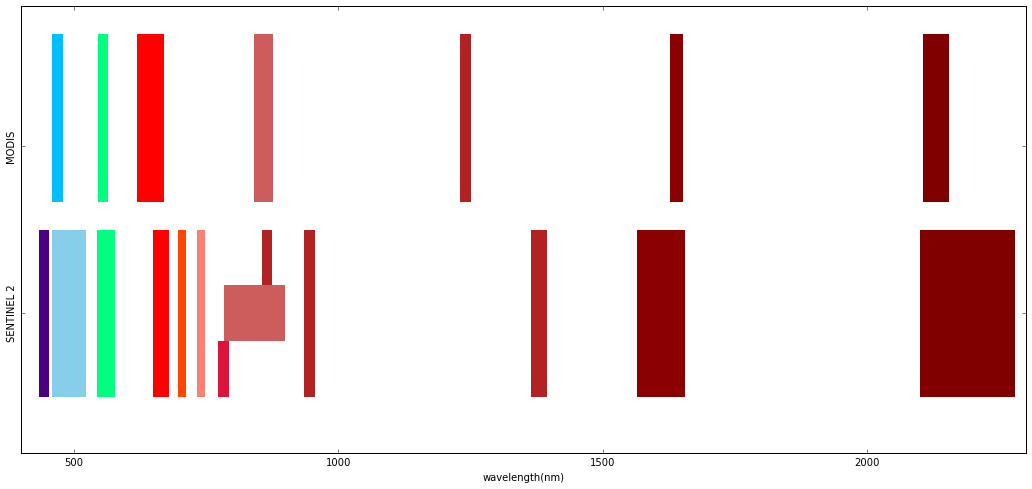

In [34]:
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline

fig,ax = plt.subplots(figsize=(18,8))
#ax.broken_barh(cb, (9.75, 0.25), facecolors=cs)
ax.broken_barh(sb[:6], (1, 3), facecolors=('indigo', 'skyblue','springgreen','red',
                                       'orangered','salmon','crimson','indianred','firebrick',
                                       'firebrick','firebrick','darkred','maroon'),linewidth = 0)
ax.broken_barh(sb[6:7], (1, 1), facecolors='crimson', linewidth = 0)
ax.broken_barh(sb[7:8], (2, 1), facecolors='indianred', cmap = cmap,  linewidth = 0)
ax.broken_barh(sb[8:9], (3, 1), facecolors='firebrick', linewidth = 0)
ax.broken_barh(sb[9:], (1, 3), facecolors=('firebrick','firebrick','darkred','maroon'), linewidth = 0)

ax.broken_barh(mb, (4.5, 3),facecolors=('deepskyblue','springgreen','red','indianred', 
                                        'firebrick','darkred','maroon'), linewidth = 0)
ax.set_ylim(0, 8)
ax.set_xlim(400, 2300)
ax.set_xlabel('wavelength(nm)')
ax.set_yticks([2.5, 5.5])
ax.set_yticklabels(['SENTINEL 2', 'MODIS'],rotation = 'vertical')
ax.grid(False)

#cbaxes = fig.add_axes([1,-1,0,0.01]) 
#s = plt.colorbar(ax, cax = cbaxes)

In [31]:
ax.set_yticklabels?

From this img we can see that the corresponding bands are 2,3,4,8,8a,11,12 for sentinel2 and 1,2,3,4,6,7 for MODIS and sentinel 8 and 8a corresponding to the same band 5 of MODIS.

In [111]:
import pylab as plt
%matplotlib inline
#plt.plot(np.unique(px))

In [355]:
import pylab as plt
plt.figure(figsize=(15,15))
plt.imshow(p_lat, interpolation = 'none')

In [228]:
m.toLatLon('50SMH')

(37.942085319765845, 115.86192606806833)

In [224]:
m.toLatLon('50SMG')

(37.040893542510126, 115.87551977006001)

In [225]:
m.toLatLon('50SNG')

(37.04622247590853, 117.0)

In [227]:
m.toLatLon('50SNH')

(37.94758957178304, 117.0)

In [2]:
import gdal
import sys
sys.path.insert(0,'python')
from fast_rw import *

In [25]:
import glob
modis_files = glob.glob('m_data/*')

In [49]:
g = gdal.Open(modis_files[0])
fnames = [i[0]for i in g.GetSubDatasets()]

In [50]:
def r_modis(fnames):
    g = gdal.Open(fnames)
    if g is None:
        raise IOError
    else:
        return g.ReadAsArray()

<matplotlib.colorbar.Colorbar instance at 0x7f6f740e6b90>

/home/ucfafyi/.conda/envs/gdal_env/lib/python2.7/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


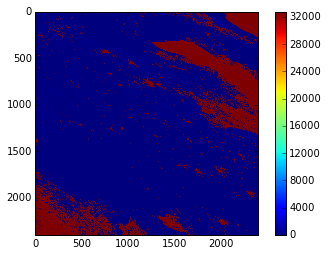

In [57]:
import pylab as plt
%matplotlib inline
plt.imshow(r_modis(fnames[0])[0])
plt.colorbar()

In [33]:
doys = [i.split('A201')[1].split('.h27')[0][1:] for i in modis_files]

In [42]:
import datetime
dates = zip([datetime.datetime(2015, 1, 1) + datetime.timedelta(int(i) - 1) for i in doys[:4]],doys[:4])\
+zip([datetime.datetime(2016, 1, 1) + datetime.timedelta(int(i) - 1) for i in doys[4:]],doys[4:])

In [43]:
dates

[(datetime.datetime(2015, 12, 3, 0, 0), '337'),
 (datetime.datetime(2015, 12, 11, 0, 0), '345'),
 (datetime.datetime(2015, 12, 19, 0, 0), '353'),
 (datetime.datetime(2015, 12, 27, 0, 0), '361'),
 (datetime.datetime(2016, 1, 1, 0, 0), '001'),
 (datetime.datetime(2016, 1, 9, 0, 0), '009'),
 (datetime.datetime(2016, 1, 17, 0, 0), '017'),
 (datetime.datetime(2016, 1, 25, 0, 0), '025'),
 (datetime.datetime(2016, 2, 2, 0, 0), '033'),
 (datetime.datetime(2016, 2, 10, 0, 0), '041'),
 (datetime.datetime(2016, 2, 18, 0, 0), '049'),
 (datetime.datetime(2016, 2, 26, 0, 0), '057'),
 (datetime.datetime(2016, 3, 5, 0, 0), '065'),
 (datetime.datetime(2016, 3, 13, 0, 0), '073'),
 (datetime.datetime(2016, 3, 21, 0, 0), '081'),
 (datetime.datetime(2016, 3, 29, 0, 0), '089'),
 (datetime.datetime(2016, 4, 6, 0, 0), '097'),
 (datetime.datetime(2016, 4, 14, 0, 0), '105'),
 (datetime.datetime(2016, 4, 22, 0, 0), '113'),
 (datetime.datetime(2016, 4, 30, 0, 0), '121'),
 (datetime.datetime(2016, 5, 8, 0, 0), '12